# Energy Requirements of Silicon Manufacturing

This journal creates a baseline for the energy required to manufacture silicon for PV applications. The processes covered here include silica to MG-Si, MG-Si to polysilicon (siemens and FBR), Cz ingot growth, wafering, and cell processing steps. 



In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10, 6)
cwd = os.getcwd() #grabs current working directory

## Silica to MG-Si

After mining cleaning the silica sand to sufficient purity (>95%), the silica sand is mixed with carboniferous materials and undergoes carbothermic reduction to extract the silicon. This is referred to as metallurgical grade silicon, or MG-Si. The carbothermic reduction is generally done in an arc furnace, frequently an electric arc furnace.

In [2]:
cwd = os.getcwd() #grabs current working directory
#skipcols = ['Source', 'Notes','Country']
e_reducesilica_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-reduceSilicaSi.csv",
                                     index_col='year')#, usecols=lambda x: x not in skipcols)

In [3]:
e_reducesilica_raw.dropna(how='all')

,E_reduce_SilicatoMGSi,Fuel_Prct,Source,Notes
year,,,,
1990,51.34,22.0,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","electrical process, thermal, and GER of carbon..."
1995,13.89,0.0,"R. Dones and R. Frischknecht, “Life-cycle asse...",arc furnace
2004,11.00,0.0,"N. Jungbluth, “Life cycle assessment of crysta...",NaN
2008,13.50,0.0,"Bleiwas, Donald. 2011. “Estimates of Electrici...",NaN
2009,12.00,0.0,"B. S. Xakalashe and M. Tangstad, “Silicon proc...",NaN
2016,27.00,56.0,"Chen Z, Ma W, Wu J, Wei K, Yang X, Lv G, Xie K...","also used by Chen 2017, total energy in = elec..."
2017,13.10,0.0,"Chen Z, Ma W, Wei K, Wu J, Li S, Xie K, Lv G. ...","data from chinese arc furnace, 4 mo, median of..."
2020,11.00,0.0,"A. Müller, L. Friedrich, C. Reichel, S. Herceg...","SoSi, modified Seimens, from Ecoinvent3.7, Fth..."
2022,17.40,37.0,"S. M. Heidari and A. Anctil, “Country-specific...","uses Muller electricity as above from PVPS, in..."


Text(0, 0.5, '[kWh/kg]')

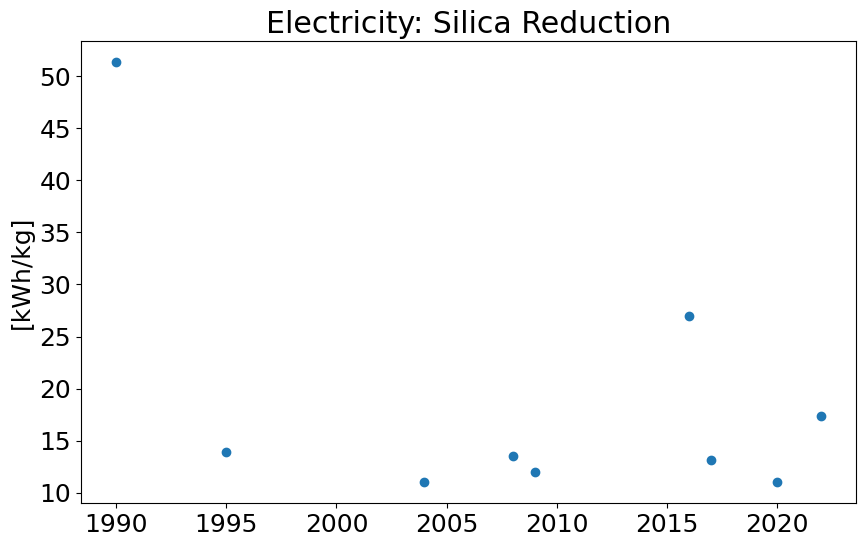

In [4]:
plt.scatter(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,0])
plt.title('Electricity: Silica Reduction')
plt.ylabel('[kWh/kg]')

Two of the energy points are higher than the others, 1990 from Phylipsen and Alsema, and 2016 from Chen et al. From Phylipsen and Alsema, the note explains that 51.34 kWh/kg is the sum of direct process energy (13 kWh/kg) and the primary energy demand of the carbon inputs+carbon electrodes (11.4kWh/kg). Similarly, Chen et al 2016 has 27 kWh/kg as the sum of electricity plus carbon inputs+carbon electrodes. The final datapoint from Heidari and Anctil also includes electricity plus carbon; they use the 2020 Muller/PVPS electricity value of 11 kWh/kg.

Subtract the electricity requirement from the total energy requirement to get a trend in carbon energy requirement.

In [5]:
pa_1990 = e_reducesilica_raw.loc[1990,'E_reduce_SilicatoMGSi']-13.0 #Phylipsen Alsema
pa_1990

38.34

In [6]:
chen_2016 = e_reducesilica_raw.loc[2016,'E_reduce_SilicatoMGSi']-12.0 #Chen Fig. 2
chen_2016

15.0

In [7]:
ha_2022 = round(e_reducesilica_raw.loc[2022,'E_reduce_SilicatoMGSi']-11.0, 1) #Heidari Anctil
ha_2022

6.4

From these data, we see that the electrical requirements of the arc furnace range from 11-13.5 kWh/kg and a decrease in the carboniferous material input required. We will create a trend and use that to increase the energy demand of the electricity only numbers

In [8]:
idx = e_reducesilica_raw.index
d = {1990:pa_1990, 2016:chen_2016, 2022:ha_2022}
e_reduce_carbonpart = pd.Series(d, index=idx, dtype=float, name='E_reduce_carbonpart')

Do a linear interpolation to fill in data

In [9]:
e_reduce_carbonpart_filled = e_reduce_carbonpart.interpolate()

Text(0, 0.5, 'Carbon-based energy [kWh/kg]')

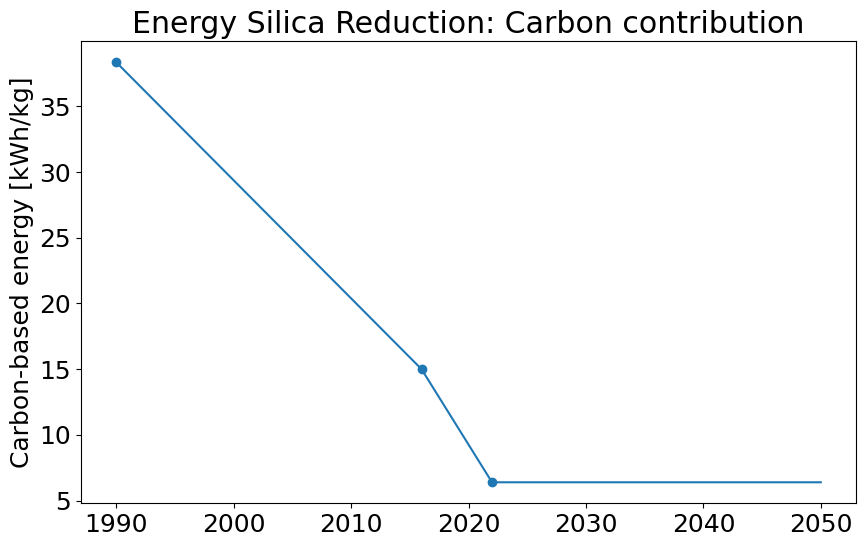

In [10]:
plt.scatter(e_reduce_carbonpart.index, e_reduce_carbonpart)
plt.plot(e_reduce_carbonpart_filled)
plt.title('Energy Silica Reduction: Carbon contribution')
plt.ylabel('Carbon-based energy [kWh/kg]')

#### Electricity Contribution
Literature values for electric arc furnaces range from 11-13 kWh/kg of MG-Si. Chen et al 2017 notes that while electric arc furnaces in EU countries have energy demands around 11 kWh/kg, Chinese arc furnaces average around 13.1 kWh/kg. The marketshare of Chinese MG-Si has increased in the last decade, as documented in Heidari and Anctil 2022 (derived from USGS 2020, Figure 3.D) between 2005 and 2018.

Pre 2005, we will do a linear interpolation between 1990 values and 2005 values.

2005-2018, we will do a marketshare weighting of RoW = 11 kWh/kg and China = 13 kWh/kg.

2018 through 2030, we will do a linear interpolation down to 11 kWh/kg, assuming continued improvement.

In [33]:
e_reducesilica = e_reducesilica_raw.loc[1995:2004,['E_reduce_SilicatoMGSi']]
#e_reducesilica

In [34]:
#2005-2018
mrktshr_mgsi_region = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-marketshareMGSiProdRegion.csv", index_col='year')
mrktshr_mgsi_region['MarketShare_RoW_MGSi'] = 1.0-mrktshr_mgsi_region['MarketShare_Chinese_MGSi']
mrktshr_mgsi_region['MarketShare_Chinese_MGSi']*=13 #multiply by kWh/kg China
mrktshr_mgsi_region['MarketShare_RoW_MGSi']*=11 #multiply by kWh/kg RoW
wtd_mrktshr_mgsi_region = pd.DataFrame(mrktshr_mgsi_region.sum(axis=1)) #sum weighted kWh/kg, is a series
wtd_mrktshr_mgsi_region.columns=['E_reduce_SilicatoMGSi'] #rename for merge/join
#wtd_mrktshr_mgsi_region

In [35]:
#2018-2030, linear decrease to 11 kWh/kg in 2030
e_reducesilica_end = pd.DataFrame(columns=['E_reduce_SilicatoMGSi'], index=range(2019,2051))
e_reducesilica_end.index.name='year'
e_reducesilica_end.loc[2030,['E_reduce_SilicatoMGSi']] = 11
#e_reducesilica_end

In [42]:
#join all together
e_reducesilica_gappy = pd.concat([e_reducesilica,wtd_mrktshr_mgsi_region,e_reducesilica_end])
#e_reducesilica_gappy

In [37]:
e_reducesilica_gaps = e_reducesilica_gappy.astype(float) #for some reason this was objects?!
e_reducesilica_full = e_reducesilica_gaps.interpolate() #linearly interpolate between points
#e_reducesilica_trim = e_reducesilica_full.loc[1995:,['E_reduceSilicatoMGSi']] #trim to 1995-2050

Text(0, 0.5, 'Electricity Demand [kWh/kg]')

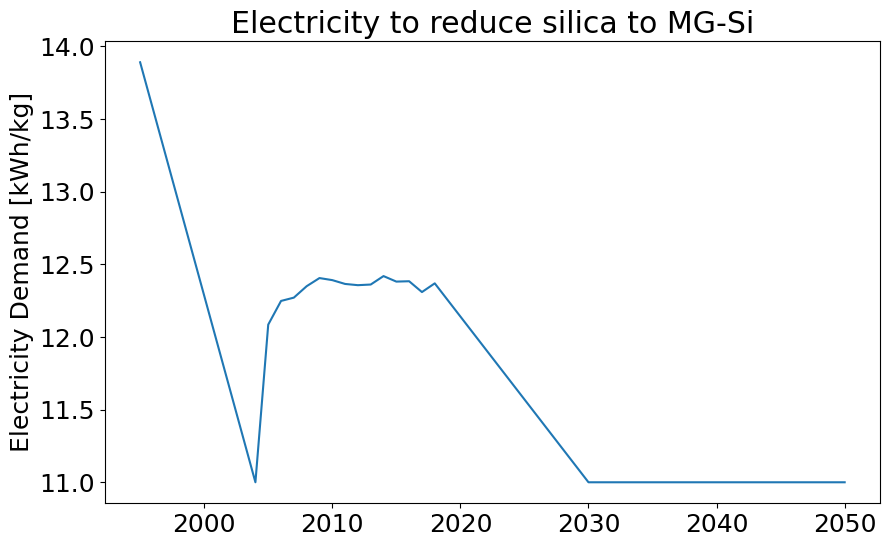

In [41]:
plt.plot(e_reducesilica_full)
#plt.scatter(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,0], color='black')
plt.title('Electricity to reduce silica to MG-Si')
plt.ylabel('Electricity Demand [kWh/kg]')

Combine Eletricity needs with Carboniferous energy

In [45]:
e_reduce = pd.concat([e_reducesilica_full,e_reduce_carbonpart_filled], axis=1, join='inner')

In [48]:
e_reduce['E_reduce_sum'] = e_reduce.sum(axis=1) #run only once if possible

Create fuel fraction column

In [60]:
#run only once if possible
e_reduce['E_FuelFraction'] = e_reduce['E_reduce_carbonpart']/e_reduce['E_reduce_sum'] 

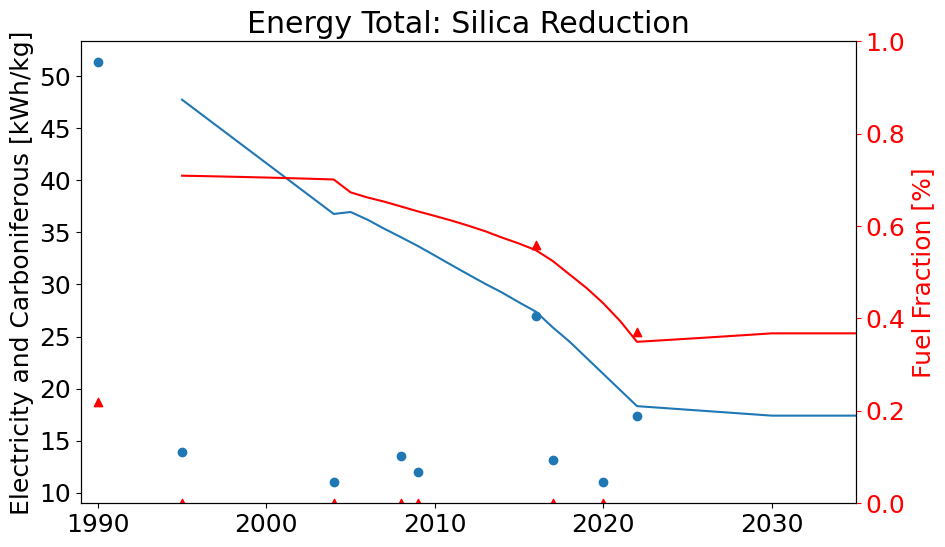

In [68]:
fig, ax1 = plt.subplots()

ax1.plot(e_reduce['E_reduce_sum'], label='Total Energy')
ax1.scatter(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,0], label='raw energy data')

ax1.set_ylabel('Electricity and Carboniferous [kWh/kg]')

ax2 = ax1.twinx()
ax2.plot(e_reduce['E_FuelFraction'], color='red', label='Fuel Fraction')
ax2.scatter(e_reducesilica_raw.index,e_reducesilica_raw.iloc[:,1]/100, 
            color='red', marker='^', label='raw fuel fraction data')
ax2.set_ylim(0,1.0)
plt.ylabel('Fuel Fraction [%]', color='red')
ax2.tick_params(axis='y', color='red', labelcolor='red')

plt.xlim(1989,2035)
plt.title('Energy Total: Silica Reduction')

#ax1.legend(loc='upper right')
#ax2.legend(loc='upper right')
plt.show()

## Refine MG-Si to Solar or Electrical Grade polysilicon

The next step in crystalline silicon PV cell manufacturing is purifying or refining the metallurgical grade silicon to solar or electronic grade polysilicon. Currently this is primarily done through the Seimens process, which entails conversion through trichlorosilane:

    Si(s) + 3HCl = HSiCl3 + H2        (26)  followed by HSiCl3 + 3H = Si + 3HCl
    This reaction occurs at 350°C normally without a catalyst. A competing reaction is 
    Si(s) + 4HCl = SiCl4 + 2H2        (27) 
    contributing to the formation of unsuitable tetrachlorosilane in molar proportion of 10 to 20%."
    "for  each  mole  of  Si  converted  to  polysilicon,  3  to  4  moles  are  converted  to SiCl4,"
    "The present market of fumed silica is about 60 000 MT measured in terms of silicon unit. This presently corresponds to three times the  output  of  polysilicon  in  2000."
	A. CIFTJA, “Refining and Recycling of Silicon: A Review,” NORWEGIAN UNIVERSITY OF SCIENCE AND TECHNOLOGY, Feb. 2008.

Here we will combine the steps of MG-Si to Trichlorosilane and trichlorosilane to polysilicon electricity demands. Please note these are electricity demands, not total ENERGY demands.

We will create energy values for both the Siemens process and the FBR process as options for user.

In [120]:
#skipcols = ['Source', 'Notes','Country']
e_refinesilicon_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-refineMGtoSo.csv",
                                     index_col='year')#, usecols=lambda x: x not in skipcols)

In [121]:
#split siemens and fbr dataframes
e_refineSi_siemens = e_refinesilicon_raw.iloc[:,0:4]
#e_refineSi_fbr = e_refinesilicon_raw.iloc[:,3:5]

### Siemens

In [122]:
e_refineSi_siemens.dropna(how='all')

,E_refineSiemens_kWhpkg,E_Siemens_FuelFraction,Source,Notes
year,,,,
1990,215.00,NaN,"G. J. M. Phylipsen and E. A. Alsema, “Environm...","estimated thermal values from Hagedorn 1989, G..."
1995,129.00,NaN,"R. Dones and R. Frischknecht, “Life-cycle asse...","electronic grade Si, may include Cz process?"
1996,305.00,NaN,"E. D. Williams, R. U. Ayres, and M. Heller, “T...",Si to TriClSi*yields + TriClSi to poly so it i...
1997,120.00,NaN,"K. Kato, A. Murata, and K. Sakuta, “Energy pay...",NaN
1998,100.00,NaN,"B. S. Xakalashe and M. Tangstad, “Silicon proc...",from reference 15 dated 1998
2004,150.00,23.0,"N. Jungbluth, “Life cycle assessment of crysta...",NaN
2005,160.00,32.0,"M. de Wild-Scholten and E. A. Alsema, “Environ...",NaN
2006,160.00,32.0,"E. Alsema and M. de Wild-Scholten, “Reduction ...",NaN
2007,110.00,NaN,"E. Bracquene, J. R. Peeters, W. Dewulf, and J....",NaN


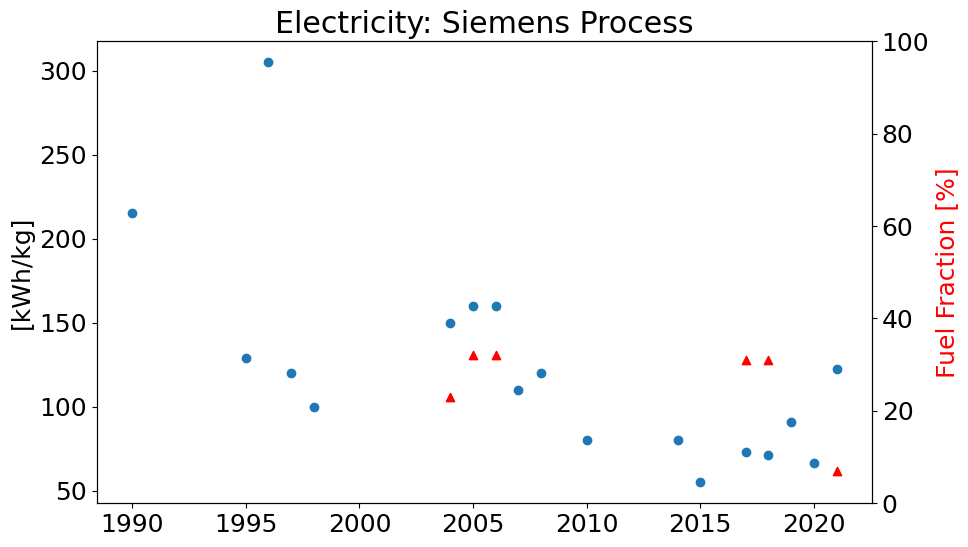

In [123]:
fig, ax1 = plt.subplots()

ax1.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,0])
plt.title('Electricity: Siemens Process')
ax1.set_ylabel('[kWh/kg]')

ax2 = ax1.twinx()

ax2.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,1], color='red', marker='^')
ax2.set_ylim(0,100)
plt.ylabel('Fuel Fraction [%]', color='red')

plt.show()

Starting with the major outlier in 1996 from Williams et al 2002. This data point is the sum of 250 and 50 from Table 3, and the data is sourced from 3 citations ranging from 1990 through 1998. It is noted that this is the electrical energy for the two Siemens steps. Handbook from 1990 has the 250, 305 enegries but these are for small reactors, Takegoshi 1996 is unavailable, Tsuo et al 1998 state "about 250 kWh/kg" number with no citation.  Therefore we will exclude Williams et al. 

In [124]:
e_refineSi_siemens.loc[1996] = np.nan #removing Williams et al.

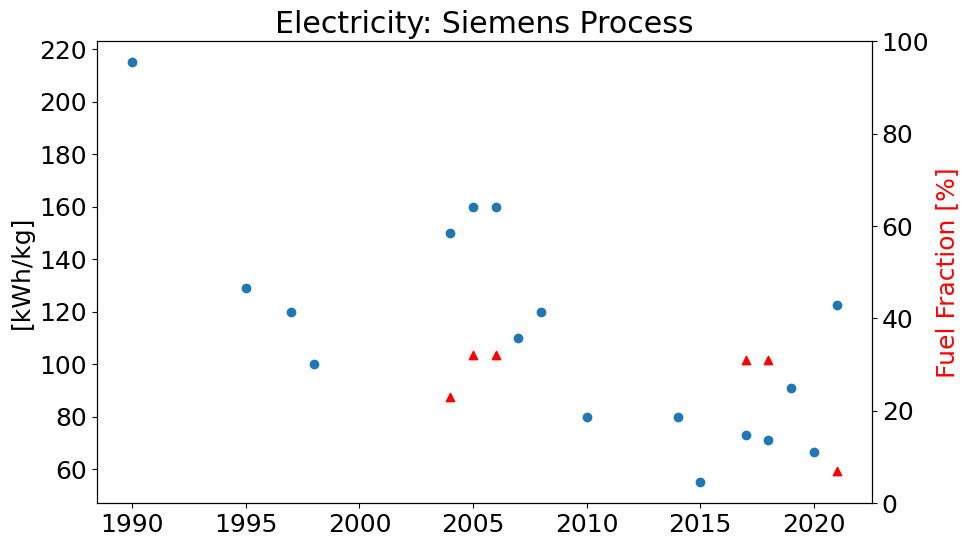

In [125]:
fig, ax1 = plt.subplots()

ax1.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,0])
plt.title('Electricity: Siemens Process')
ax1.set_ylabel('[kWh/kg]')

ax2 = ax1.twinx()

ax2.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,1], color='red', marker='^')
ax2.set_ylim(0,100)
plt.ylabel('Fuel Fraction [%]', color='red')

plt.show()

There is noise, but generally there is an observable downward trend. I will try a curve fit for the total energy demand, and use 31 % fuel fraction since this seems to be constant, and the final low datapoint (Fan et al 2021) is an estimation.

In [157]:
e_refineSi_siemens.loc[1995:2000] = np.nan #removing low looking data for fitting

In [158]:
 e_siemens_fitting = e_refineSi_siemens.dropna(how='all')

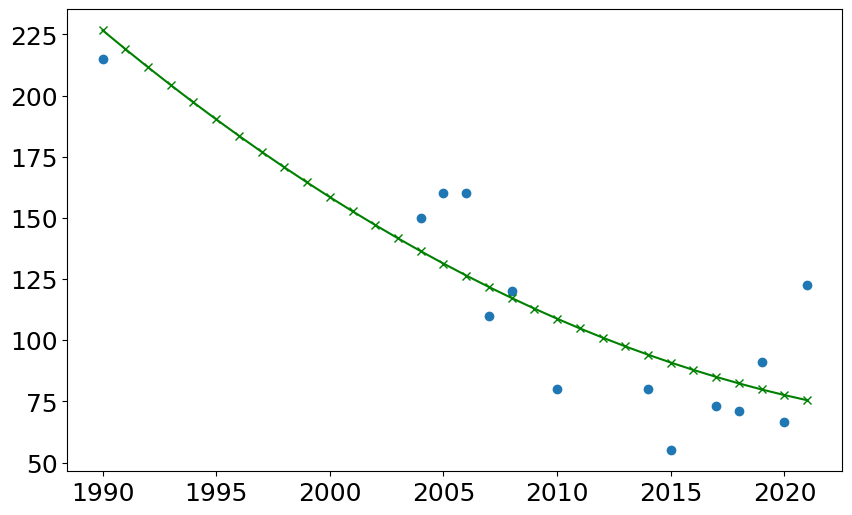

In [201]:
#fit polynomial
x = e_siemens_fitting.index
y = e_siemens_fitting.loc[:,'E_refineSiemens_kWhpkg']
model1 = np.poly1d(np.polyfit(x, y, 2))

#create data for plotting
polyline = np.linspace(1990, 2021, 32) #(start, stop, number=2021-1990)

#plot for viewing
plt.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,0])
plt.plot(polyline, model1(polyline), color='green', marker='x')
plt.show()

In [216]:
#extract the values of the fitted data
e_siemens_fitting1 = pd.DataFrame(model1(polyline), index=polyline.astype(int),
                                  columns=['E_refineSiemens_kWhpkg'])

In [203]:
#define function to calculate adjusted r-squared
def adjR(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results['r_squared'] = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))

    return results


Check the Adjusted R squared fit value for the linear and the quad fit:

In [204]:
adjR(x, y, 1) #linear

{'r_squared': 0.6744552367670376}

In [205]:
adjR(x, y, 2) #quad 

{'r_squared': 0.6837220086638651}

The quad fit is slightly better than the linear. Now we will compare it to an interpolation

In [218]:
e_siemens_fitting2 = e_refineSi_siemens.iloc[:,[0,1]]
e_siemens_fitting2.loc[2021] = np.nan #remove Fan et al 2021
e_siemens_fitting2.interpolate(limit_direction='both', inplace=True)

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_19284\4149674213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_siemens_fitting2.loc[2021] = np.nan #remove Fan et al 2021
C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_19284\4149674213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_siemens_fitting2.interpolate(limit_direction='both', inplace=True)


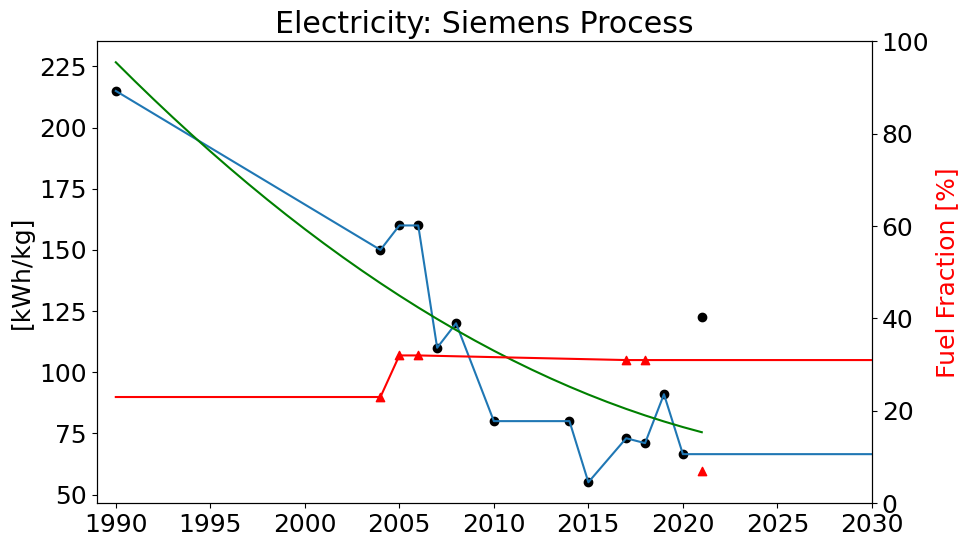

In [219]:
fig, ax1 = plt.subplots()

ax1.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,0], color='black')
ax1.plot(e_siemens_fitting2.index,e_siemens_fitting2.iloc[:,0])
ax1.plot(e_siemens_fitting1, color='green')

plt.title('Electricity: Siemens Process')
ax1.set_ylabel('[kWh/kg]')

ax2 = ax1.twinx()

ax2.scatter(e_refineSi_siemens.index,e_refineSi_siemens.iloc[:,1], color='red', marker='^')
ax2.plot(e_siemens_fitting2.index,e_siemens_fitting2.iloc[:,1], color='red')

ax2.set_ylim(0,100)
plt.ylabel('Fuel Fraction [%]', color='red')

ax2.set_xlim(1989,2030)

plt.show()

The fitted curve does a decent job of representing the raw data while smoothing the noise. Therefore we will use the fitted data through 2021 and then hold it constant. We will also use a constant 31% Fuel fraction.

In [233]:
e_siemens_fitting1['E_refine_FuelFraction'] = 31.0 #add fuel fraction column and set to 31
#extend index through 2050 and fill (uses idx from above)
e_siemens_final = e_siemens_fitting1.reindex(idx).fillna(method='ffill') 

### FBR
Currently disregarded due to small market share

In [ ]:
e_refineSi_fbr.dropna(how='all')

## Ingot growth

The next step in manufacturing silicon PV is ingot growth. There are two primary methods of ingot growth in the PV industry over it's history; multi-crystalline silicon and monocrystalline silicon. Initially, all PV was monocrystalline, then Multicrystalline silicon ingots were the dominent market share for most of a decade, and currently monocrystalline is making a resurgence to market dominence. We will cover the energy associated with both processes here, and weight the historical energy demand by the marketshare of these two technologies.

In [ ]:
e_ingotenergy_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-ingotgrowing.csv",
                                     index_col='year')

### Multi-crystalline Silicon

mc-Si is created through putting chunked polysilicon into a large block, heating and casting into a single large block. This process results in many crystallographic grains within the block, which slightly reduces the efficiency of the cell, but is cheap. 

In [ ]:
e_casting_raw = e_ingotenergy_raw.iloc[:,3:6]
e_casting_raw.dropna(how='all')

In [ ]:
plt.scatter(e_casting_raw.index, e_casting_raw['E_mcSiCast_kWhpkg'])

The two high outliers are Fan et al and Woodhouse et al. Both of these datapoint include the wafering, which we prefer to calculate separately, therefore we will drop these two points, and use them later as a check that our energy demands are lining up.

Next the energy seems to step up and then down over time. This is potenially real due the increasing size of blocks over time.

In [ ]:
e_casting_manual = e_casting_raw.copy()
e_casting_manual.loc[2016] = np.nan #drop Fan et al
e_casting_manual.loc[2018] = np.nan # drop Woodhouse et al

In [ ]:
plt.scatter(e_casting_manual.index, e_casting_manual['E_mcSiCast_kWhpkg'])
plt.ylim(5,16)
plt.title('Electricity: DS of mc-Si')
plt.ylabel('Electricity Demand [kWh/kg]')

From this lovely scatter plot graph, we can see that the energy demand of directional solification casting for mc-Si has not particularly changed in the last decades. Therefore, we will take an average of these datapoints and apply it for all time.

In [ ]:
e_casting_mcSi = e_casting_manual['E_mcSiCast_kWhpkg'].mean()
print('The electrical energy to make mc-Si through direct solidification is '+str(e_casting_mcSi)+' kWh/kg.')

### Mono-crystalline Silicon

mono-Si is created through the Czochralski process, in which a seed crystal is rotated and drawn away from a vat of molten silicon, growing a large boule. This results in the whole boule/ingot being oriented in one crystallographic direction, which increases the cell efficiency, but is time consuming and expensive.

In [ ]:
e_growczingot_raw = e_ingotenergy_raw.iloc[:,0:3]
e_growczingot_raw.dropna(how='all')

In [ ]:
plt.scatter(e_growczingot_raw.index, e_growczingot_raw['E_Cz_kWhpkg'])
plt.title('Electricity: Cz Ingot Growth')
plt.ylabel('[kWh/kg]')

There is a general downward trend. There is a lot of noise at the end. The 2016 datapoint from Fan et al is much higher, as is Woodhouse et al 2018. Fan et al data is the average of Chinese manufacturers surveys and literature data. Both sources include the wafering step (Which we prefer to calculate separately). Therefore we will drop both datapoints for this calculation, but use them as a reality check later for energy demand of the two steps.

Knapp 1999 is lower than Jungbluth 2004. This is possible, but is a very small difference in overall energy demand (117 vs 123 kWh/kg). Therefore, we will take the average of the two points, and set both dates equal to that average.

Lastly, the final datapoint from Muller et al ticks upward slightly, however, the previous datapoint is from ITRPV which is a global survey report whereas the Muller et al is an updated LCI ostensibly with real world data. Therefore, we will leave this slight increase  given the data quality and non-drastic change.

In [ ]:
e_growczingot_manual = e_growczingot_raw.copy()
e_growczingot_manual.loc[2016] = np.nan #drop Fan et al
e_growczingot_manual.loc[2018] = np.nan # drop Woodhouse et al

In [ ]:
avg = np.mean([e_growczingot_manual.loc[1999,'E_Cz_kWhpkg'], e_growczingot_manual.loc[2004,'E_Cz_kWhpkg']])
e_growczingot_manual.loc[1999] = avg
e_growczingot_manual.loc[2004] = avg

In [ ]:
e_ingotcz_filled = e_growczingot_manual.interpolate()

In [ ]:
plt.plot(e_ingotcz_filled.index, e_ingotcz_filled['E_Cz_kWhpkg'])
plt.scatter(e_growczingot_raw.index, e_growczingot_raw['E_Cz_kWhpkg'], color='black')
plt.title('Electricity: Cz Ingot Growth')
plt.ylabel('[kWh/kg]')
plt.xlim(1993,2021)

### Market Share Weight mono-Si vs mc-Si
Here we blend the two calculated data into an annual average energy demand based on the marketshare of installed cell type.

In [ ]:
pvice_mcSimono_marketshare = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_scaledmrktshr_mcSi_mono.csv",
                                     index_col='Year')

In [ ]:
e_ingotcz = e_ingotcz_filled.loc[1995:,['E_Cz_kWhpkg']] #slice Cz dataframe
e_ingots = e_ingotcz.copy() #create new df for math
e_ingots['E_DS_kWhpkg'] = e_casting_mcSi #add column for mcsi DS
pvice_mcSimono_marketshare_trim = pvice_mcSimono_marketshare.loc[1995:,] #trim the marketshare to start in 1995
pvice_mcSimono_marketshare_extend = pvice_mcSimono_marketshare_trim.interpolate() #fill through 2050

e_ingots_wtd = pd.DataFrame(index=e_ingots.index) #create new df for math
e_ingots_wtd['mono'] = pvice_mcSimono_marketshare_extend['monoSi']*e_ingots['E_Cz_kWhpkg'] #mrktshr mono*CZ energy
e_ingots_wtd['mocsi'] = pvice_mcSimono_marketshare_extend['mcSi']*e_ingots['E_DS_kWhpkg'] #mrktshr mcSi*DS energy
e_ingots_wtd_final = pd.DataFrame(e_ingots_wtd.sum(axis=1)) # sum the annual energy demand PV Si ingot growth
e_ingots_wtd_final.columns =['E_Ingot_kWhpkg']

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(e_ingots_wtd_final, label='Wtd Avg Electricity Demand')
ax1.scatter(e_growczingot_raw.index, e_growczingot_raw['E_Cz_kWhpkg'], color='black', label='CZ, mono-Si, raw data')
ax1.scatter(e_casting_raw.index, e_casting_raw['E_mcSiCast_kWhpkg'], color='green', 
            marker='^', label='DS, mc-Si, raw data')
ax1.set_ylabel('Electricity Demand [kWh/kg]')

ax2 = ax1.twinx()
ax2.plot(pvice_mcSimono_marketshare_trim['monoSi'], color ='orange', label='Mono Si Market Share', ls=':', lw=3)
ax2.set_ylim(0,1.0)
plt.ylabel('Market Share Monocrystalline Si [%]', color='orange')
ax2.tick_params(axis='y', color='red', labelcolor='orange')

plt.xlim(1989,2030)
plt.title('Electricity: Weighted Average of Si Ingot Growth')

ax1.legend(loc='upper center')
plt.show()

## Wafering Electricity

This step captures the electricity demands of wafering the grown silicon ingot (CZ or DS) into wafers. This includes the prep and demounting as well as the sawing step itself.

In [ ]:
e_wafering_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-wafering.csv",
                             index_col='year')

In [ ]:
e_wafering_raw.dropna(how='all')

In [ ]:
plt.scatter(e_wafering_raw.index, e_wafering_raw['E_Wafering_kWhpkg']) 

In [ ]:
e_wafering_trim_drop=e_wafering_raw.loc[1995:,['E_Wafering_kWhpkg']]
e_wafering_trim_drop.loc[1997] = np.nan # this is an outlier

In [ ]:
e_wafering_filled = e_wafering_trim_drop.interpolate()
#e_wafering_filled

In [ ]:
plt.plot(e_wafering_filled, label='interpolated')
plt.scatter(e_wafering_raw.index, e_wafering_raw['E_Wafering_kWhpkg'], label='raw', color='black') 
plt.title('Electricity demand: Wafering')
plt.ylabel('[kWh/kg]')
plt.xlim(1989,2023)

## Cell Production Electricity

In [ ]:
e_cellprocess_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/energy-input-silicon-cellProcess.csv",
                             index_col='year')
e_cellprocess_raw.dropna(how='all')

In [ ]:
plt.scatter(e_cellprocess_raw.index, e_cellprocess_raw['E_cellProcess_kWhpkg'])

There appear to be 2 outliers - Woodhouse 2018 is estimated machine-by-machine, and might be high. The 1994 datapoint is outrageously high, not sure why. Also got an outlier number from V. Fthenakis and E. Leccisi 2021, despite claiming to use the Frischknecht PVPS report. Dropping outliers and then interpolating.

In [ ]:
e_cellprocess = e_cellprocess_raw.copy()
e_cellprocess.loc[1994] = np.nan
e_cellprocess.loc[2018] = np.nan
#e_cellprocess.dropna(how='all')

In [ ]:
e_cellprocess_fill = e_cellprocess.loc[1990:,['E_cellProcess_kWhpkg']] 
e_cellprocess_fill.interpolate(inplace=True)
e_cellprocess_final = e_cellprocess_fill.loc[1995:,['E_cellProcess_kWhpkg']] 

In [ ]:
plt.plot(e_cellprocess_final)
plt.scatter(e_cellprocess_raw.index, e_cellprocess_raw['E_cellProcess_kWhpkg'], color='black')
plt.xlim(1989,2023)
plt.ylabel('[kWh/kg Si]')
plt.title('Electricity Demand: Cell Processing')

## Combine All MFG energy

Now we will combine all of the manufacturing steps associated with silicon and the silicon wafer into a single dynamic column, e_mat_MFG. This will get multiplied by the virgin material stock required to manufacture PV modules annually.

In [ ]:
mfg_energies = [e_reducesilica_trim, e_refineSi_siemens_final, e_ingots_wtd_final, e_wafering_filled, e_cellprocess_final]
df_mfg_energies = pd.concat(mfg_energies, axis=1)
df_mfg_energies['e_mfg_kWhpkg'] = round(df_mfg_energies.sum(axis=1),2)

In [ ]:
df_mfg_energies.columns

In [ ]:
plt.plot([],[],color='blue', label='Reduce Si')
plt.plot([],[],color='orange', label='Refine Si')
plt.plot([],[],color='brown', label='Ingot')
plt.plot([],[],color='green', label='Wafer')
plt.plot([],[],color='red', label='Cell')

plt.stackplot(df_mfg_energies.index, df_mfg_energies['E_reduceSilicatoMGSi'], 
              df_mfg_energies['ErefineSiemens kWh/kg'],
              df_mfg_energies['E_Ingot_kWhpkg'], 
              df_mfg_energies['E_Wafering_kWhpkg'], 
              df_mfg_energies['E_cellProcess_kWhpkg'],
             colors = ['blue','orange','brown','green','red'])
plt.title('Electricity: Silicon Manufacturing')
plt.ylabel('Electricity Demand [kWh/kg]')
plt.xlim(1995,2022)
plt.legend()
plt.show()

In [ ]:
plt.plot(df_mfg_energies.index, df_mfg_energies['e_mfg_kWhpkg'])
plt.title('Electricity: Silicon Manufacturing')
plt.ylabel('Electricity Demand [kWh/kg]')
plt.xlim(1995,2022)
plt.ylim(0,)

Now to check this overall electricity demand against literature values as a reality check. Doing VERY ROUGH ballpark checks.

In [ ]:
#N. Jungbluth, “Life cycle assessment of crystalline photovoltaics in the Swiss ecoinvent database,” 
#Progress in Photovoltaics: Research and Applications, vol. 13, no. 5, pp. 429–446, 2005, doi: 10.1002/pip.614.
#mgSi, EgSi, Cz growth, cell process in kWh/kg
jungbluth2005_kWh=11+103+123+22

#Wild-Scholten, M. J. de. 2013. “Energy Payback Time and Carbon Footprint of Commercial Photovoltaic Systems.” 
#Solar Energy Materials and Solar Cells, Thin-film Photovoltaic Solar Cells, 119: 296–305.
#https://doi.org/10.1016/j.solmat.2013.08.037.
#Primary Energy demand, sum of feedstock, ingot, cell Mono, convert MJ to kWh
wildscholten2013_kWh = (961+73.4+81.4)*0.27777 

#Phylipsen, G J M, and E A Alsema. 1995. “Environmental Life-Cycle Assessment of Multicrystalline 
#Silicon Solar Cell Modules.” Netherlands: Netherlands Agency for Energy and the Environment,NOVEM.
# direct process energy requirement-module production, table 4.1, worst case
phyl_alsema1995_kWh= (511-27) #kWh/m2 to kWh/kg estimating 5 kg/module

In [ ]:
plt.plot(df_mfg_energies.index, df_mfg_energies['e_mfg_kWhpkg'])

#literature
plt.scatter(1995, phyl_alsema1995_kWh, color='pink')
plt.scatter(2005, jungbluth2005_kWh, color='purple')
plt.scatter(2011, wildscholten2013_kWh, color='black')
#plt.scatter(2020, , color='red')


plt.title('Electricity: Silicon Manufacturing')
plt.ylabel('Electricity Demand [kWh/kg]')
plt.xlim(1994,2022)
plt.ylim(0,)

In [ ]:
df_mfg_energies['e_mfg_kWhpkg'].to_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_energy_silicon_mfg.csv")

## EOL Recycling to HQ energy Calculation

No literature found recycled EOL silicon to higher than MG-Si. Therefore, we will use the extraction energy at EOL from Latunussa et al 2016 (1.6 kWh/kg) for the FRELP process as the LQ. We will also add this quantity to the energy to MFG as calculated here, from Seimens forward. 

In [ ]:
latunussa2016 = 1.6 #kWh/kg
e_eol_recycle = df_mfg_energies['e_mfg_kWhpkg']-df_mfg_energies['E_reduceSilicatoMGSi'] #creates a series
e_eol_recycle_HQ = round(e_eol_recycle+latunussa2016,2)
e_eol_recycle_HQ.to_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_energy_silicon_eol_recycleHQ.csv")